In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import joblib

In [73]:
def eval_metrics(y_true, y_pred, y_proba=None):
    """Return accuracy, precision, recall, f1, roc_auc"""
    d = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="binary", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="binary", zero_division=0),
        "F1": f1_score(y_true, y_pred, average="binary", zero_division=0)
    }
    if y_proba is not None:
        d["AUC"] = roc_auc_score(y_true, y_proba)
    else:
        d["AUC"] = np.nan
    return d


In [74]:
def plot_roc(y_true, y_proba, label):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_true, y_proba):.3f})")


In [76]:
def train_and_evaluate(df, dataset_name="dataset"):
    """Train models, evaluate, print metrics and plot ROC"""
    X = df.drop(columns=["num"])
    y = df["num"]

    # Convert to binary if multi-class
    if y.nunique() > 2:
        y = (y > 0).astype(int)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42)
    }

    results = {}

    plt.figure(figsize=(7,7))
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Handle probability output
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
        else:
            y_proba = model.decision_function(X_test)
            # scale to [0,1]
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-12)

        # Metrics
        metrics = eval_metrics(y_test, y_pred, y_proba)
        results[name] = metrics

        # ROC curve
        plot_roc(y_test, y_proba, name)

        # Print Confusion Matrix + Classification Report
        print(f"\n📌 {name} Results:")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

    # Final ROC curve
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {dataset_name}")
    plt.legend()
    plt.show()

    return pd.DataFrame(results).T.round(3)



Evaluating Reduced Feature dataset...

📌 Logistic Regression Results:
Confusion Matrix:
[[29  3]
 [ 7 21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.85        32
           1       0.88      0.75      0.81        28

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60


📌 Decision Tree Results:
Confusion Matrix:
[[26  6]
 [10 18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        32
           1       0.75      0.64      0.69        28

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60


📌 Random Forest Results:
Confusion Matrix:
[[28  4]
 [ 7 21]]

Classification Report:
              precision    recall  f1-sco

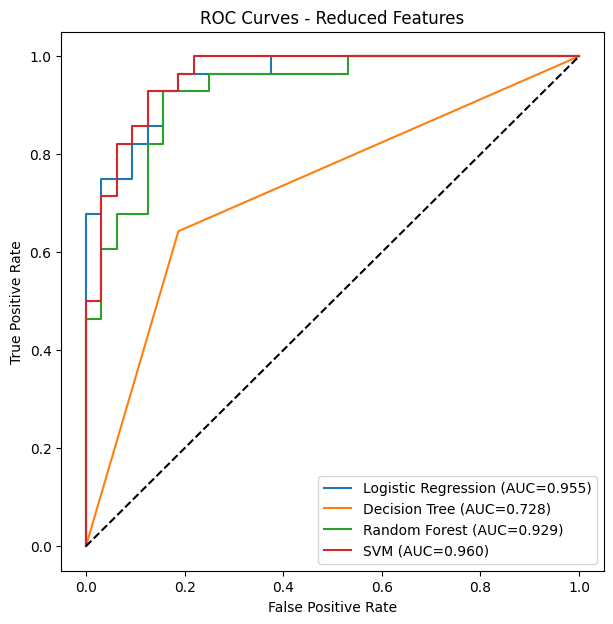


📊 Summary Results:
                     Accuracy  Precision  Recall     F1    AUC
Logistic Regression     0.833      0.875   0.750  0.808  0.955
Decision Tree           0.733      0.750   0.643  0.692  0.728
Random Forest           0.817      0.840   0.750  0.792  0.929
SVM                     0.867      0.917   0.786  0.846  0.960


In [77]:
df = pd.read_csv("../data/reduced_heart.csv")

print("Evaluating Reduced Feature dataset...")
results = train_and_evaluate(df, "Reduced Features")

print("\n📊 Summary Results:")
print(results)

In [78]:
X = df.drop(columns=["num"])
y = (df["num"] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

best_model = LogisticRegression(max_iter=2000, random_state=42)
best_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [80]:
joblib.dump(best_model, "../models/final_model.pkl")
print("✅ Best model saved to models/final_model.pkl")

✅ Best model saved to models/final_model.pkl
